In [1]:
import json
import os
from torch_geometric.utils.convert import to_networkx
import networkx as nx
import matplotlib.pyplot as plt
import torch
import numpy as np
import random
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from trainer import *

Load HypersimDataset

In [2]:
config = load_config()

In [3]:
dataset = load_dataset_small(config)
print('Dataset length:', len(dataset))

classes = [1, 2, 8, 11, 12, 18]
print('\nClasses selected:', config['dataset']['classes'], '\nie. ', dataset.scene_names[classes])

print('\nEach class label above is mapped to a new class label in the range 0-number of selected classes.\nThe mapping is as follows:', dataset.class_mapping)
print('This is necessary for training with pytorch.')

print('\nSample data point:', dataset[0])
print('with node labels:\n', dataset[0].x[:5], '...,')
print('and adjacency list:\n', dataset[0].edge_index)
print('and graph label:', dataset[0].y, 'ie.', dataset.scene_names[classes][dataset[0].y.item()])

Dataset length: 49017

Classes selected: 1, 2, 8, 11, 12, 18 
ie.  ['Bathroom' 'Bedroom' 'Kitchen' 'Living room' 'Office' 'Restaurant']

Each class label above is mapped to a new class label in the range 0-number of selected classes.
The mapping is as follows: {1: 0, 2: 1, 8: 2, 11: 3, 12: 4, 18: 5}
This is necessary for training with pytorch.

Sample data point: Data(x=[32, 1], edge_index=[2, 534], y=[1])
with node labels:
 tensor([[40],
        [40],
        [27],
        [38],
        [13]]) ...,
and adjacency list:
 tensor([[ 0,  0,  0,  ..., 31, 31, 31],
        [ 1,  2,  3,  ...,  3,  5, 30]])
and graph label: tensor([0]) ie. Bathroom


Visualise graphs from HypersimDataset (need to download images from raw dataset first)

Current graph visualised: data_11.pt


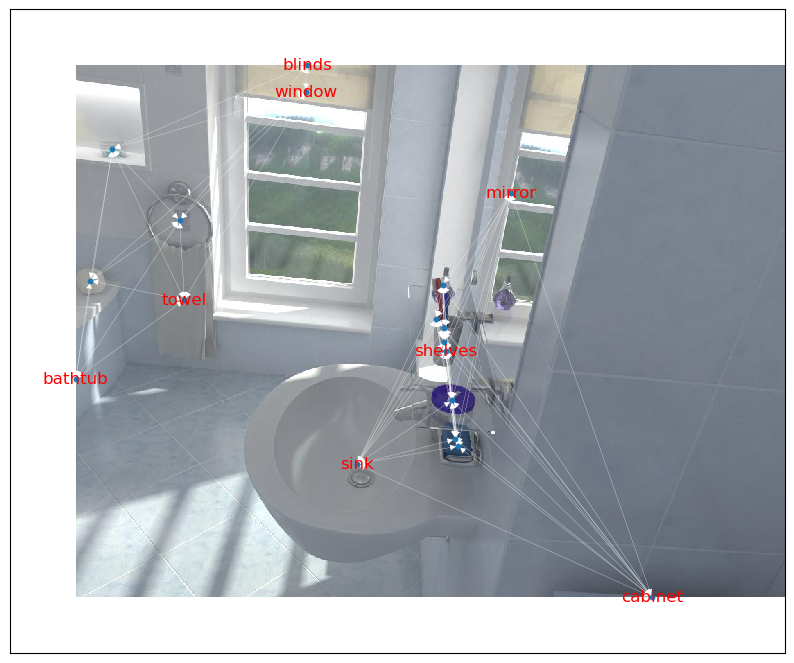

In [4]:
from utils import *
idx = random.randint(0, len(dataset))
visualize_graph(dataset, idx)

Sample smaller, balanced dataset

In [5]:
file = './checkpoints/class_indices_dict.json'
if  os.path.isfile(file):
    with open(file, 'r') as f:
        class_indices_dict = json.load(f)

# Randomly select {samples_per_class} samples from each class of dataset_small
random_indices = []
samples_per_class = int(config['dataset']['samples_per_class'])
for class_indices in class_indices_dict.values():
    random_indices.extend(random.sample(class_indices, samples_per_class))

In [6]:
dataset = dataset[random_indices]
dataset

HypersimDataset(30)

Create dataloader

In [7]:
train_loader = DataLoader(dataset, batch_size=int(config['datamodule']['batch_size']), shuffle=False, drop_last=False)

Setup GCN model (defined as in Pytorch Geometric tutorial: https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=N-FO5xL3mw98)

In [8]:
from torch.optim.lr_scheduler import ExponentialLR

model_name = config['model']['model_name']
model = globals()[model_name](feature_size=1, hidden_channels=int(config['model']['hidden_channels']))
print('Model:\n', model)
print('\nNo. parameters:', sum(p.numel() for p in model.parameters()))

# For Adam
optimizer_name = config['model']['optimizer']
optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=float(config['model']['lr']))

# For SGD
# optimizer_name = config['model']['optimizer']
# optimizer = getattr(optim, optimizer_name)(
#     model.parameters(),
#     lr=float(config['model']['lr']),
#     momentum=float(config['model']['sgd_momentum']),  # Set the momentum parameter here
#     weight_decay=float(config['model']['weight_decay']),  # Set the weight_decay parameter here
# )
# scheduler = ExponentialLR(optimizer, gamma=float(config['model']['scheduler_gamma']))  # Set the scheduler_gamma parameter here

criterion_name = config['model']['criterion']
criterion = getattr(nn, criterion_name)()

num_epochs = int(config['trainer']['epochs'])

Model:
 GCN(
  (conv1): GCNConv(1, 16)
  (conv2): GCNConv(16, 16)
  (conv3): GCNConv(16, 16)
  (lin): Linear(in_features=16, out_features=6, bias=True)
)

No. parameters: 678


Training

In [9]:
def train_one_epoch_d(train_loader, model, optimizer, criterion):
    model.train()
    for data in train_loader:
        optimizer.zero_grad()
        out, _ = model(data.x.float(), data.edge_index.type(torch.long), data.batch.type(torch.long))
        loss = criterion(out, data.y.type(torch.long))
        loss.backward()
        optimizer.step()

In [11]:
if eval(config['wandb']['log']) == True:
    wandb.init(project=config['wandb']['project_name'], name=config['wandb']['run_name'])
    wandb.config.update(config)

for epoch in range (num_epochs):
    train_one_epoch_d(train_loader, model, optimizer, criterion)
    train_acc = test_model(train_loader, model)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

    # Logging to wandb
    if eval(config['wandb']['log']) == True:
        wandb.log({"Train Accuracy": train_acc})

print("done")
wandb.finish()

Epoch: 000, Train Acc: 0.2667
Epoch: 001, Train Acc: 0.2667
Epoch: 002, Train Acc: 0.3000
Epoch: 003, Train Acc: 0.3333
Epoch: 004, Train Acc: 0.2667
Epoch: 005, Train Acc: 0.2333
Epoch: 006, Train Acc: 0.3000
Epoch: 007, Train Acc: 0.2667
Epoch: 008, Train Acc: 0.2667
Epoch: 009, Train Acc: 0.2667
Epoch: 010, Train Acc: 0.2667
Epoch: 011, Train Acc: 0.3333
Epoch: 012, Train Acc: 0.3000
Epoch: 013, Train Acc: 0.3667
Epoch: 014, Train Acc: 0.2667
Epoch: 015, Train Acc: 0.3667
Epoch: 016, Train Acc: 0.4000
Epoch: 017, Train Acc: 0.3000
Epoch: 018, Train Acc: 0.3333
Epoch: 019, Train Acc: 0.3333
Epoch: 020, Train Acc: 0.3333
Epoch: 021, Train Acc: 0.3333
Epoch: 022, Train Acc: 0.3667
Epoch: 023, Train Acc: 0.3333
Epoch: 024, Train Acc: 0.3000
Epoch: 025, Train Acc: 0.3333
Epoch: 026, Train Acc: 0.3667
Epoch: 027, Train Acc: 0.4000
Epoch: 028, Train Acc: 0.3333
Epoch: 029, Train Acc: 0.2333
Epoch: 030, Train Acc: 0.3333
Epoch: 031, Train Acc: 0.4333
Epoch: 032, Train Acc: 0.4333
Epoch: 033